In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_labels = pd.read_json('150sim_cluster_labels.json')
pressure_factor = pd.read_json('150sim_pressure_factor.json')
n_clusters = 30

Get results:

In [6]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

Downsampling

In [7]:
n_sampl = 4
sampl_ind = np.arange(0,len(results.node['pressure'].index),4)

In [8]:
results.node = {key: val.iloc[sampl_ind] for key, val in results.node.items()}
results.link = {key: val.iloc[sampl_ind] for key, val in results.link.items()}

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [9]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [10]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


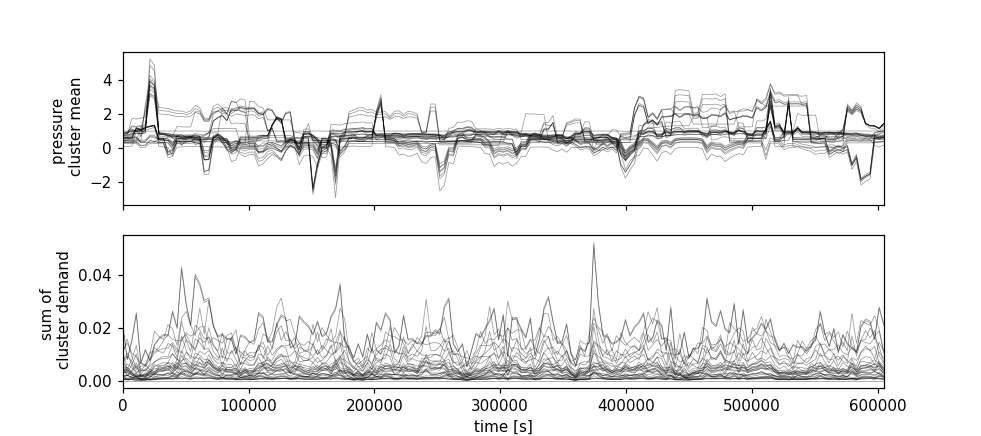

In [11]:
fig, ax = plt.subplots(2,1,figsize=(9,4), sharex=True)
jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[0].set_ylabel('pressure \n cluster mean')


jun_cl_demand_sum.plot(ax=ax[1], legend=False, linewidth=0.5, color='k', alpha=0.4)
ax[1].set_ylabel('sum of \n cluster demand')

ax[1].set_xlabel('time [s]')
plt.show()

Quick validation if everything that flows into/ out of a cluster is in fact equal to the sum of demands within the cluster: 

In [12]:
start_node = nw_link_df.loc['start_node'].apply(lambda x: x.name)
end_node = nw_link_df.loc['end_node'].apply(lambda x: x.name)
flow_out = results.link['flowrate'].copy()
flow_out = flow_out.groupby(start_node, axis=1).sum()
flow_in = results.link['flowrate'].copy()
flow_in = flow_in.groupby(end_node, axis=1).sum()

In [13]:
cluster_in = flow_in.groupby(cluster_labels.loc['pressure_cluster'], axis=1).sum()
cluster_out = flow_out.groupby(cluster_labels.loc['pressure_cluster'], axis=1).sum()

In [14]:
(cluster_in-cluster_out-jun_cl_demand_sum).head(3)

pressure_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
0,4.656613e-10,1.117587e-08,2.083834e-08,3.725290e-09,0.000000e+00,9.778887e-08,1.862645e-09,-4.656613e-10,3.725290e-09,4.656613e-10,...,0.000000e+00,1.792796e-08,NaN,2.444722e-09,1.746230e-10,0.0,4.423782e-09,1.327135e-08,0.000000e+00,4.656613e-10
3600,-6.519258e-09,2.142042e-08,2.328306e-09,7.450581e-09,-1.164153e-10,1.527369e-07,-9.313226e-10,-1.396984e-09,1.629815e-09,0.000000e+00,...,0.000000e+00,1.257285e-08,NaN,1.571607e-09,-3.492460e-10,0.0,-7.858034e-10,-4.656613e-09,1.164153e-10,-2.328306e-09
7200,4.656613e-09,-1.117587e-08,-6.938353e-08,-6.146729e-08,-2.328306e-10,4.004687e-08,-4.656613e-09,4.656613e-10,-2.793968e-09,2.328306e-10,...,9.313226e-10,1.816079e-08,NaN,5.820766e-11,-4.074536e-10,0.0,7.101335e-09,2.677552e-08,-2.328306e-10,-4.656613e-10


### Tanks

In [15]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


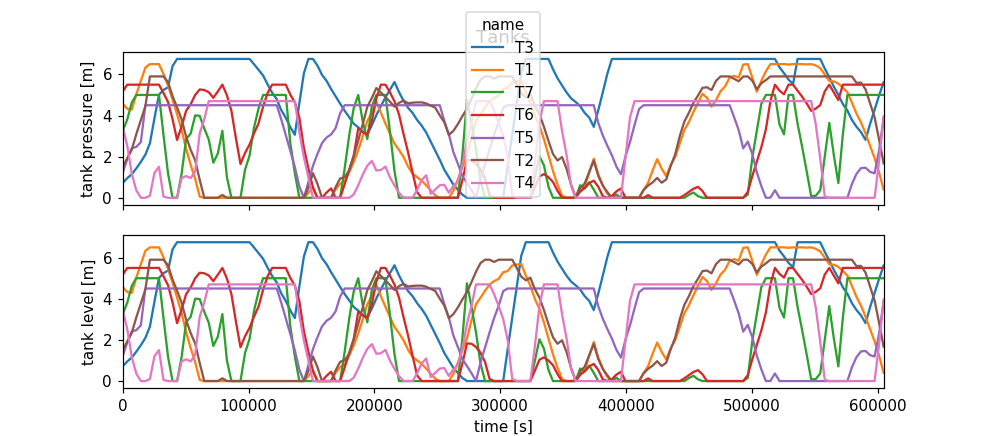

Text(0.5, 0, 'time [s]')

In [16]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))
tank_press.plot(ax=ax[0])
ax[0].set_title('Tanks')
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

### Reservoirs

In [17]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


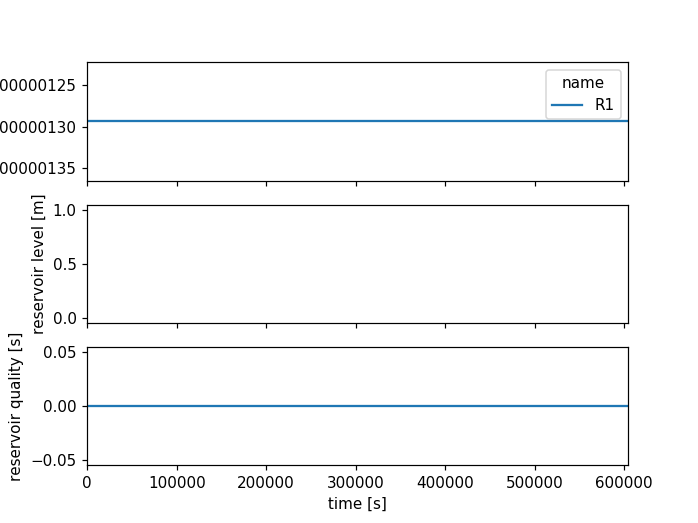

Text(0.5, 0, 'time [s]')

In [18]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [19]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

<IPython.core.display.Javascript object>


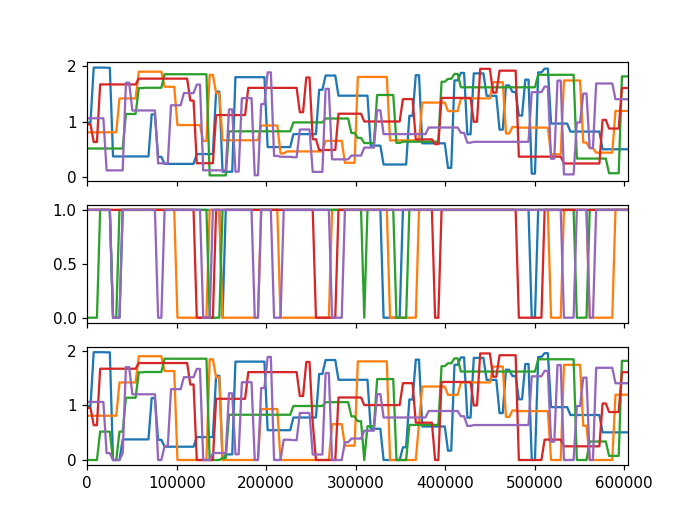

In [20]:
fig, ax = plt.subplots(3,1, sharex=True)
head_pump_speed.plot(ax=ax[0],legend=False)
head_pump_status.plot(ax=ax[1],legend=False)
head_pump_speed_corr.plot(ax=ax[2],legend=False)

In [21]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,58.227444,14.631674,0.0,26.532584,23.435502
3600,59.667405,15.006451,0.0,26.596325,23.251882
7200,388.669375,15.140445,0.0,5.978760,23.596270


<IPython.core.display.Javascript object>


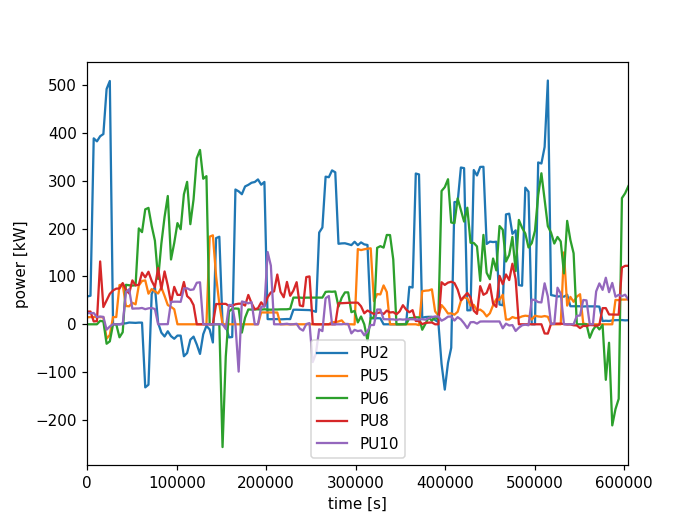

Text(0.5, 0, 'time [s]')

In [22]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [23]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


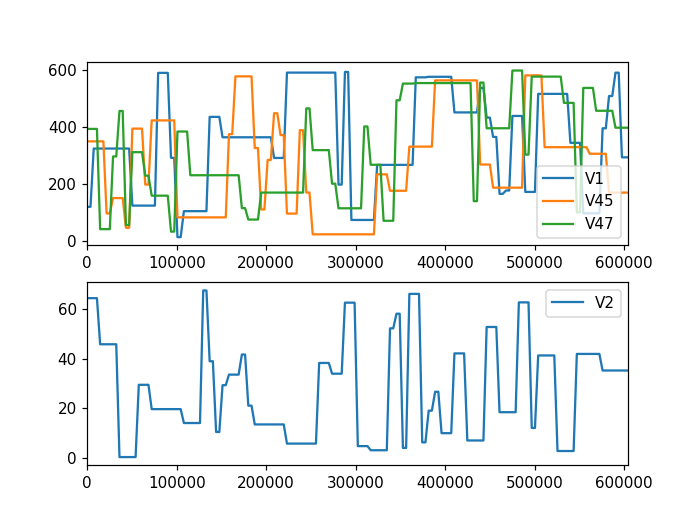

In [24]:
fig, ax = plt.subplots(2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [25]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed_corr,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [26]:
dsys_states = sys_states.diff(axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)
sys_states_next = sys_states.shift(-1, axis=0)

nn_output_dict = {#'sys_states': dsys_states_next,
                 'sys_states': sys_states_next,
                 'aux_outputs': aux_outputs
                 }
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [27]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0             0.272864  0.916604  0.761406  0.890894  0.824592  0.329666   
3600          0.275156  1.033682  1.745429  1.261227  1.312243  0.349746   
7200          0.274443  1.024858  1.709364  1.232713  1.273086  0.356747   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0     0.899453  0.528362  0.902472  0.546372  ...   3.805309  5.497543   
3600  1.031661  0.574991  1.093703  0.584271  ...   4.629975  5.499999   
7200  1.025321  1.177917  1.033084  1.187841  ...   4.999999  5.499999   

                                   aux_outputs                             \
                                   pump_energy                              
            T5        T2        T4         PU2        PU5  PU6        PU8   
0     1.878209  1.916962  2.534390   58.227444  14.631674  0.0  26.532584   
3600  2.408828  2.343187  1.167404   59.667405  15.006451  0.0  26.596325   
7200  2.475930  3.096202  0.363025  388.669375  15.140445  0.0   5.978760   

                 
                 
           PU10  
0     23.435502  
3600  23.251882  
7200  23.596270  

[3 rows x 42 columns]

Inputs of the neural network:

In [28]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (169, 76)


NARX model structure?

In [29]:
if True:
    n_arx = 4
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, keys=np.arange(n_arx), names=['NARX', 'type', 'name', 'index'], axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (169, 304)


In [30]:
nn_input.head(3)

NARX                  0                                                    \
type         sys_states                                                     
name  jun_cl_press_mean                                                     
index                0         1         2         3         4         5    
0              0.289451  0.903845  0.735164  0.869797  0.795174  0.359890   
3600           0.272864  0.916604  0.761406  0.890894  0.824592  0.329666   
7200           0.275156  1.033682  1.745429  1.261227  1.312243  0.349746   

NARX                                           ...                 3          \
type                                           ...        sys_inputs           
name                                           ... jun_cl_demand_sum           
index        6         7         8         9   ...                20  21  22   
0      0.883972  0.524466  0.839315  0.542478  ...               NaN NaN NaN   
3600   0.899453  0.528362  0.902472  0.546372  ...               NaN NaN NaN   
7200   1.031661  0.574991  1.093703  0.584271  ...               NaN NaN NaN   

NARX                               
type                               
name                               
index  23  24  25  26  27  28  29  
0     NaN NaN NaN NaN NaN NaN NaN  
3600  NaN NaN NaN NaN NaN NaN NaN  
7200  NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 304 columns]

Check if NARX structure works:

In [31]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(5)

NARX,0,1,2,3
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
0,0.289451,NaN,NaN,NaN
3600,0.272864,0.289451,NaN,NaN
7200,0.275156,0.272864,0.289451,NaN
10800,0.274443,0.275156,0.272864,0.289451
14400,0.027201,0.274443,0.275156,0.272864


Filter inputs and outputs:

In [32]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (165, 304)


In [33]:
print(nn_input.isnull().any().any())
print(nn_output.isnull().any().any())

False
False


In [34]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(3)

NARX,0,1,2,3
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
10800,0.274443,0.275156,0.272864,0.289451
14400,0.027201,0.274443,0.275156,0.272864
18000,0.055141,0.027201,0.274443,0.275156


In [35]:
pd.DataFrame(nn_output['sys_states','jun_cl_press_mean',0]).head(3)

,sys_states
,jun_cl_press_mean
,0
10800,0.027201
14400,0.055141
18000,0.290220


### Compare to external output function:

This function is used to create the complete dataset for training.

In [36]:
file_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_15_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_16_try.pkl',
            #'/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_17_try.pkl'
            ]

nn_input_ext, nn_output_ext = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "/home/ffiedler/Documents/git_repos/2019_WNTR_Surrogate_Model/Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [37]:
similar_inputs=((nn_input_ext-nn_input)==0).all().all()
print('inputs are identical: {}'.format(similar_inputs))

similar_outputs=((nn_output_ext-nn_output)==0).all().all()
print('outputs are identical: {}'.format(similar_outputs))

inputs are identical: True
outputs are identical: True


### Normalize Data:

In [65]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [67]:
X_train.shape

(132, 304)

# Neural Network

## Create Model

In [68]:
n_layer = 3
n_units = 70
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 70)                21350     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_5 (Dense)              (None, 42)                2982      
Total params: 29,302
Trainable params: 29,302
Non-trainable params: 0
_________________________________________________________________


## Train model

In [69]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [70]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=100, 
                    epochs=2000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 132 samples, validate on 33 samples
Epoch 1/2000
132/132 [==============================] - 1s 6ms/sample - loss: 0.2833 - val_loss: 0.2288
Epoch 2/2000
132/132 [==============================] - 0s 562us/sample - loss: 0.2183 - val_loss: 0.1891
Epoch 3/2000
132/132 [==============================] - 0s 710us/sample - loss: 0.1750 - val_loss: 0.1604
Epoch 4/2000
132/132 [==============================] - 0s 578us/sample - loss: 0.1446 - val_loss: 0.1397
Epoch 5/2000
132/132 [==============================] - 0s 620us/sample - loss: 0.1232 - val_loss: 0.1239
Epoch 6/2000
132/132 [==============================] - 0s 778us/sample - loss: 0.1067 - val_loss: 0.1115
Epoch 7/2000
132/132 [==============================] - 0s 1ms/sample - loss: 0.0940 - val_loss: 0.1017
Epoch 8/2000
132/132 [==============================] - 0s 965us/sample - loss: 0.0838 - val_loss: 0.0939
Epoch 9/2000
132/132 [==============================] - 0s 1ms/sample - loss: 0.0757 - val_loss: 0.0876
Epoch 1

132/132 [==============================] - 0s 567us/sample - loss: 0.0125 - val_loss: 0.0435
Epoch 78/2000
132/132 [==============================] - 0s 600us/sample - loss: 0.0123 - val_loss: 0.0434
Epoch 79/2000
132/132 [==============================] - 0s 738us/sample - loss: 0.0122 - val_loss: 0.0432
Epoch 80/2000
132/132 [==============================] - 0s 602us/sample - loss: 0.0120 - val_loss: 0.0430
Epoch 81/2000
132/132 [==============================] - 0s 617us/sample - loss: 0.0119 - val_loss: 0.0427
Epoch 82/2000
132/132 [==============================] - 0s 673us/sample - loss: 0.0117 - val_loss: 0.0426
Epoch 83/2000
132/132 [==============================] - 0s 459us/sample - loss: 0.0116 - val_loss: 0.0425
Epoch 84/2000
132/132 [==============================] - 0s 513us/sample - loss: 0.0115 - val_loss: 0.0425
Epoch 85/2000
132/132 [==============================] - 0s 757us/sample - loss: 0.0113 - val_loss: 0.0425
Epoch 86/2000
132/132 [============================

132/132 [==============================] - 0s 488us/sample - loss: 0.0054 - val_loss: 0.0424
Epoch 154/2000
132/132 [==============================] - 0s 512us/sample - loss: 0.0054 - val_loss: 0.0424
Epoch 155/2000
132/132 [==============================] - 0s 500us/sample - loss: 0.0053 - val_loss: 0.0425
Epoch 156/2000
132/132 [==============================] - 0s 507us/sample - loss: 0.0052 - val_loss: 0.0425
Epoch 157/2000
132/132 [==============================] - 0s 505us/sample - loss: 0.0052 - val_loss: 0.0425
Epoch 158/2000
132/132 [==============================] - 0s 538us/sample - loss: 0.0052 - val_loss: 0.0424
Epoch 159/2000
132/132 [==============================] - 0s 568us/sample - loss: 0.0051 - val_loss: 0.0423
Epoch 160/2000
132/132 [==============================] - 0s 554us/sample - loss: 0.0051 - val_loss: 0.0423
Epoch 161/2000
132/132 [==============================] - 0s 563us/sample - loss: 0.0050 - val_loss: 0.0423
Epoch 162/2000
132/132 [===================

132/132 [==============================] - 0s 371us/sample - loss: 0.0026 - val_loss: 0.0443
Epoch 230/2000
132/132 [==============================] - 0s 374us/sample - loss: 0.0026 - val_loss: 0.0444
Epoch 231/2000
132/132 [==============================] - 0s 401us/sample - loss: 0.0026 - val_loss: 0.0445
Epoch 232/2000
132/132 [==============================] - 0s 399us/sample - loss: 0.0025 - val_loss: 0.0446
Epoch 233/2000
132/132 [==============================] - 0s 389us/sample - loss: 0.0025 - val_loss: 0.0446
Epoch 234/2000
132/132 [==============================] - 0s 386us/sample - loss: 0.0025 - val_loss: 0.0449
Epoch 235/2000
132/132 [==============================] - 0s 506us/sample - loss: 0.0025 - val_loss: 0.0450
Epoch 236/2000
132/132 [==============================] - 0s 410us/sample - loss: 0.0024 - val_loss: 0.0450
Epoch 237/2000
132/132 [==============================] - 0s 391us/sample - loss: 0.0024 - val_loss: 0.0449
Epoch 238/2000
132/132 [===================

132/132 [==============================] - 0s 580us/sample - loss: 0.0014 - val_loss: 0.0456
Epoch 306/2000
132/132 [==============================] - 0s 576us/sample - loss: 0.0014 - val_loss: 0.0455
Epoch 307/2000
132/132 [==============================] - 0s 667us/sample - loss: 0.0014 - val_loss: 0.0456
Epoch 308/2000
132/132 [==============================] - 0s 669us/sample - loss: 0.0013 - val_loss: 0.0454
Epoch 309/2000
132/132 [==============================] - 0s 601us/sample - loss: 0.0013 - val_loss: 0.0454
Epoch 310/2000
132/132 [==============================] - 0s 826us/sample - loss: 0.0013 - val_loss: 0.0456
Epoch 311/2000
132/132 [==============================] - 0s 728us/sample - loss: 0.0013 - val_loss: 0.0457
Epoch 312/2000
132/132 [==============================] - 0s 582us/sample - loss: 0.0013 - val_loss: 0.0455
Epoch 313/2000
132/132 [==============================] - 0s 604us/sample - loss: 0.0013 - val_loss: 0.0455
Epoch 314/2000
132/132 [===================

Epoch 380/2000
132/132 [==============================] - 0s 552us/sample - loss: 8.0982e-04 - val_loss: 0.0462
Epoch 381/2000
132/132 [==============================] - 0s 493us/sample - loss: 8.0221e-04 - val_loss: 0.0462
Epoch 382/2000
132/132 [==============================] - 0s 560us/sample - loss: 8.0011e-04 - val_loss: 0.0461
Epoch 383/2000
132/132 [==============================] - 0s 487us/sample - loss: 7.9679e-04 - val_loss: 0.0459
Epoch 384/2000
132/132 [==============================] - 0s 503us/sample - loss: 7.8348e-04 - val_loss: 0.0459
Epoch 385/2000
132/132 [==============================] - 0s 477us/sample - loss: 7.8887e-04 - val_loss: 0.0460
Epoch 386/2000
132/132 [==============================] - 0s 565us/sample - loss: 7.8417e-04 - val_loss: 0.0461
Epoch 387/2000
132/132 [==============================] - 0s 515us/sample - loss: 7.7969e-04 - val_loss: 0.0461
Epoch 388/2000
132/132 [==============================] - 0s 565us/sample - loss: 7.7400e-04 - val_loss:

132/132 [==============================] - 0s 345us/sample - loss: 5.2507e-04 - val_loss: 0.0467
Epoch 454/2000
132/132 [==============================] - 0s 357us/sample - loss: 5.2231e-04 - val_loss: 0.0466
Epoch 455/2000
132/132 [==============================] - 0s 374us/sample - loss: 5.1763e-04 - val_loss: 0.0466
Epoch 456/2000
132/132 [==============================] - 0s 372us/sample - loss: 5.1320e-04 - val_loss: 0.0467
Epoch 457/2000
132/132 [==============================] - 0s 361us/sample - loss: 5.1194e-04 - val_loss: 0.0465
Epoch 458/2000
132/132 [==============================] - 0s 361us/sample - loss: 5.0731e-04 - val_loss: 0.0465
Epoch 459/2000
132/132 [==============================] - 0s 393us/sample - loss: 5.0707e-04 - val_loss: 0.0466
Epoch 460/2000
132/132 [==============================] - 0s 369us/sample - loss: 5.0240e-04 - val_loss: 0.0467
Epoch 461/2000
132/132 [==============================] - 0s 523us/sample - loss: 4.9923e-04 - val_loss: 0.0467
Epoch 4

132/132 [==============================] - 0s 955us/sample - loss: 3.5771e-04 - val_loss: 0.0469
Epoch 527/2000
132/132 [==============================] - 0s 682us/sample - loss: 3.5091e-04 - val_loss: 0.0469
Epoch 528/2000
132/132 [==============================] - 0s 408us/sample - loss: 3.4858e-04 - val_loss: 0.0470
Epoch 529/2000
132/132 [==============================] - 0s 498us/sample - loss: 3.4757e-04 - val_loss: 0.0469
Epoch 530/2000
132/132 [==============================] - 0s 393us/sample - loss: 3.4878e-04 - val_loss: 0.0469
Epoch 531/2000
132/132 [==============================] - 0s 370us/sample - loss: 3.4628e-04 - val_loss: 0.0469
Epoch 532/2000
132/132 [==============================] - 0s 383us/sample - loss: 3.4344e-04 - val_loss: 0.0469
Epoch 533/2000
132/132 [==============================] - 0s 343us/sample - loss: 3.4180e-04 - val_loss: 0.0470
Epoch 534/2000
132/132 [==============================] - 0s 339us/sample - loss: 3.4149e-04 - val_loss: 0.0471
Epoch 5

132/132 [==============================] - 0s 681us/sample - loss: 2.4956e-04 - val_loss: 0.0472
Epoch 600/2000
132/132 [==============================] - 0s 717us/sample - loss: 2.4719e-04 - val_loss: 0.0473
Epoch 601/2000
132/132 [==============================] - 0s 990us/sample - loss: 2.4537e-04 - val_loss: 0.0473
Epoch 602/2000
132/132 [==============================] - 0s 802us/sample - loss: 2.4546e-04 - val_loss: 0.0473
Epoch 603/2000
132/132 [==============================] - 0s 486us/sample - loss: 2.4439e-04 - val_loss: 0.0473
Epoch 604/2000
132/132 [==============================] - 0s 545us/sample - loss: 2.4425e-04 - val_loss: 0.0473
Epoch 605/2000
132/132 [==============================] - 0s 594us/sample - loss: 2.4286e-04 - val_loss: 0.0473
Epoch 606/2000
132/132 [==============================] - 0s 544us/sample - loss: 2.4210e-04 - val_loss: 0.0472
Epoch 607/2000
132/132 [==============================] - 0s 533us/sample - loss: 2.4270e-04 - val_loss: 0.0472
Epoch 6

132/132 [==============================] - 0s 664us/sample - loss: 1.8257e-04 - val_loss: 0.0475
Epoch 673/2000
132/132 [==============================] - 0s 584us/sample - loss: 1.8155e-04 - val_loss: 0.0475
Epoch 674/2000
132/132 [==============================] - 0s 535us/sample - loss: 1.8097e-04 - val_loss: 0.0475
Epoch 675/2000
132/132 [==============================] - 0s 490us/sample - loss: 1.7977e-04 - val_loss: 0.0475
Epoch 676/2000
132/132 [==============================] - 0s 474us/sample - loss: 1.8022e-04 - val_loss: 0.0475
Epoch 677/2000
132/132 [==============================] - 0s 497us/sample - loss: 1.7864e-04 - val_loss: 0.0476
Epoch 678/2000
132/132 [==============================] - 0s 676us/sample - loss: 1.7778e-04 - val_loss: 0.0476
Epoch 679/2000
132/132 [==============================] - 0s 599us/sample - loss: 1.7698e-04 - val_loss: 0.0476
Epoch 680/2000
132/132 [==============================] - 0s 540us/sample - loss: 1.7847e-04 - val_loss: 0.0475
Epoch 6

132/132 [==============================] - 0s 510us/sample - loss: 1.3750e-04 - val_loss: 0.0477
Epoch 746/2000
132/132 [==============================] - 0s 501us/sample - loss: 1.3701e-04 - val_loss: 0.0477
Epoch 747/2000
132/132 [==============================] - 0s 473us/sample - loss: 1.3651e-04 - val_loss: 0.0478
Epoch 748/2000
132/132 [==============================] - 0s 487us/sample - loss: 1.3566e-04 - val_loss: 0.0478
Epoch 749/2000
132/132 [==============================] - 0s 527us/sample - loss: 1.3612e-04 - val_loss: 0.0477
Epoch 750/2000
132/132 [==============================] - 0s 478us/sample - loss: 1.3526e-04 - val_loss: 0.0477
Epoch 751/2000
132/132 [==============================] - 0s 557us/sample - loss: 1.3409e-04 - val_loss: 0.0478
Epoch 752/2000
132/132 [==============================] - 0s 568us/sample - loss: 1.3379e-04 - val_loss: 0.0478
Epoch 753/2000
132/132 [==============================] - 0s 535us/sample - loss: 1.3351e-04 - val_loss: 0.0478
Epoch 7

## Evaluate model

In [71]:
class narx_simulator:
    def __init__(self, model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0):
        self.model = model
        self.n_arx = n_arx
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.u = u0
        
        assert self.x.shape[0] == n_arx
        assert self.u.shape[0] == n_arx-1
        
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate(((np.flip(self.x[-self.n_arx:,:],axis=0), np.flip(self.u[-self.n_arx:,:], axis=0))),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
        
        self.x = np.append(self.x, self.nn_out[:,:self.x.shape[1]], axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        
        self.eval_nn()
        
        

In [72]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [73]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


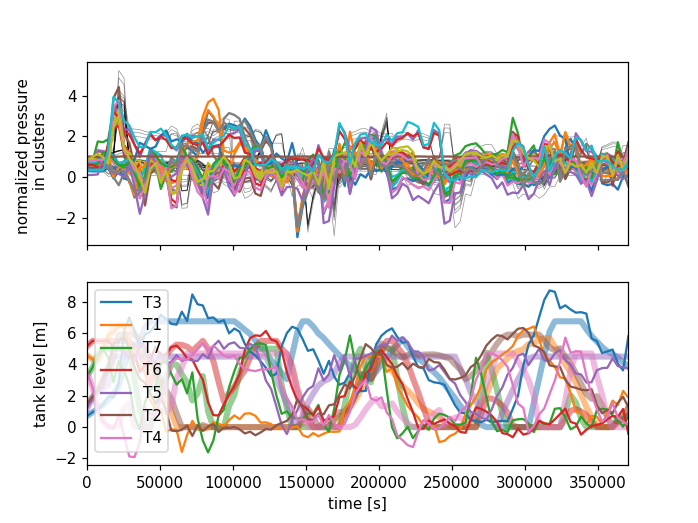

Text(0.5, 0, 'time [s]')

In [74]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [46]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [47]:
x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim_lin = narx_simulator(linear_reg, n_arx, input_scaling, output_scaling, input_offset, output_offset, x0, u0, t0)

In [48]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[n_arx+1+k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


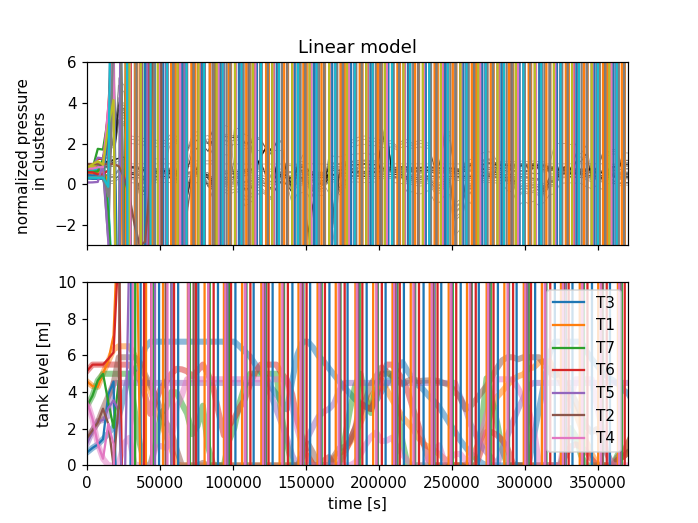

(0, 10)

In [49]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1])

ax[0].set_title('Linear model')
ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylim(-3, 6)

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

ax[1].set_ylim(0, 10)

# Create full training data set:

In [96]:
def scale(X, offset=None, scaling=None, scaling_min=1e-5):
    if np.any(offset) and np.any(scaling):
        X = (X-offset)/scaling
    else:
        offset = X.mean()
        X = X-offset
        scaling = X.abs().max()
        scaling.loc[scaling.abs()<scaling_min] = scaling_min
        X = X/scaling
    return X, offset, scaling

## Load data

In [98]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

In [99]:
nn_input, nn_output = get_data(file_list, 4, cluster_labels, pressure_factor)

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input, nn_output, test_size=0.2)

In [107]:
X_train, input_offset, input_scaling = scale(X_train)
X_test, _, _ = scale(X_test, input_offset, input_scaling)

Y_train, output_offset, output_scaling = scale(Y_train)
Y_test, _, _ = scale(Y_test, output_offset, output_scaling)

## Save everything

Pack everything needed for training in a .pkl file:

In [108]:
training_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'x_offset': input_offset,
    'x_scaling': input_scaling,
    'y_offset': output_offset,
    'y_scaling': output_scaling,
    'cluster_labels': cluster_labels,
    'pressure_factor': pressure_factor
}

with open('02_training_setup_narx4.pkl', 'wb') as f:
    results = pickle.dump(training_dict, f)

# Test external model:

In [109]:
model_path = './models/'
model_name = '000_model_01'
model_ext = keras.models.load_model(model_path+model_name+'.h5')

with open('./training_data/02_training_setup_narx4.pkl', 'rb') as f:
    train_data = pickle.load(f)
    

In [110]:
model_ext.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense (Dense)                (None, 70)                21350     
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2982      
Total params: 24,332
Trainable params: 24,332
Non-trainable params: 0
_________________________________________________________________


In [111]:
x_scaling = train_data['x_scaling']
y_scaling = train_data['y_scaling']
x_offset = train_data['x_offset']
y_offset = train_data['y_offset']

n_arx = 4

x0 = sys_states.head(n_arx).to_numpy()
u0 = sys_inputs.head(n_arx-1).to_numpy()
t0 = sys_states.head(n_arx).index.to_numpy()

nsim = narx_simulator(model_ext, n_arx, x_scaling, y_scaling, x_offset, y_offset, x0, u0, t0)

In [112]:
for k in range(100):
    sys_inputs_now = sys_inputs.iloc[n_arx+k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t)

<IPython.core.display.Javascript object>


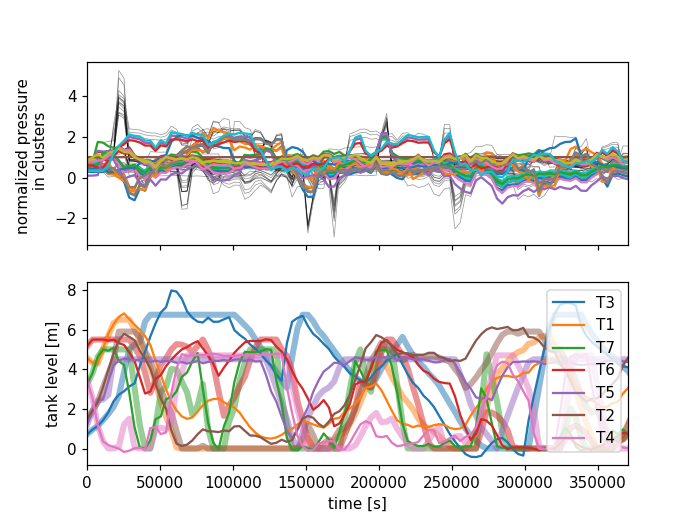

Text(0.5, 0, 'time [s]')

In [113]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, sim_res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')